In [53]:
import warnings
warnings.filterwarnings("ignore")

In [54]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score, auc
from sklearn.metrics import roc_auc_score

In [55]:
%matplotlib inline
plt.style.use('bmh')

In [56]:
# self created packages
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from scripts.visualizations import Visualization
from scripts.snowflake_sink import SnowflakeConnector

In [57]:
sns.set_theme(style="whitegrid")

In [58]:
# pyspakr ML library
from pyspark.ml.feature import VectorAssembler, ChiSqSelector, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

In [59]:
# pyspark packages
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, sum, desc, split, length, initcap, trim, lower, count, when)
from pyspark.sql.types import (
    StructType, StructField, IntegerType, StringType,
    FloatType, BooleanType, DateType, DoubleType)

In [60]:
spark = SparkSession.builder \
    .appName("Data Modeling") \
    .getOrCreate()

spark

In [61]:
ip_data = spark.read.option("header", "True") \
                .option("inferSchema", "True") \
                .option("quote", '"') \
                .option("escape", '"') \
                .option("sep", ",") \
                .option("ignoreLeadingWhiteSpace", "True") \
                .option("ignoreTrailingWhiteSpace", "True") \
                .option("multiLine", "True") \
                .option("mode", "PERMISSIVE") \
                .csv("../data/gun_violence_cleaned_data_2013_2018.csv")

print(f"Number of records in the data : {ip_data.count()}")
print(f"Number of columns: {len(ip_data.columns)}")

Number of records in the data : 239677
Number of columns: 45


In [62]:
txt_columns = ["notes"]

ip_data = ip_data.fillna("missing", subset=txt_columns)

### Classification (without the text column)

For startes we are setting the target column as `is_killed` a new column created and proceed with the classification problem.

We will also drop features such as `incident_id`, `notes`, `date`, `city_or_county`, and may be `incident_characteristics`, `year`

Not sure if `year` is needed as it might be missleading.

In [64]:
class_ip_data = ip_data.withColumn("is_killed", when(col("n_killed") > 0, 1).otherwise(0))

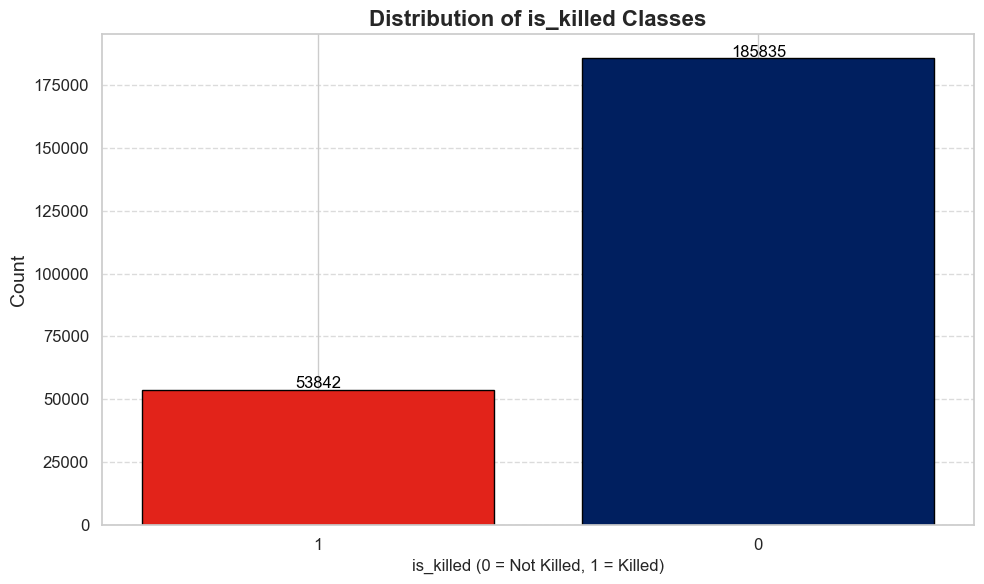

In [65]:
class_distribution = class_ip_data.groupBy("is_killed").count().toPandas()

plt.figure(figsize=(10, 6))
colors = ['#E2231A', '#001F5F']

plt.bar(class_distribution['is_killed'].astype(str), class_distribution['count'], color=colors, edgecolor='black')
plt.title('Distribution of is_killed Classes', fontsize=16, fontweight='bold')
plt.xlabel('is_killed (0 = Not Killed, 1 = Killed)', fontsize=12)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12, rotation=0, ha='center')
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, value in enumerate(class_distribution['count']):
    plt.text(i, value + 500, str(value), ha='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()

Given that the data is imbalanced, one effective approach to handle this issue is by applying class weights during training. This technique adjusts the model's learning process, assigning higher importance to the minority class and ensuring it is adequately represented in the training phase. By using class weights, the model is penalized more heavily for misclassifying examples from the underrepresented class, which can lead to improved performance, especially in imbalanced scenarios.

Alternatively, other popular techniques to address class imbalance include synthetic sampling methods like SMOTE (Synthetic Minority Over-sampling Technique) or various undersampling methods. SMOTE works by generating synthetic examples for the minority class, whereas undersampling reduces the number of instances from the majority class to balance the dataset.

For now, we will begin with using class weights during training, as it is a simple and efficient solution that can be implemented directly into the training process. If necessary, we can explore other sampling techniques later to further improve model performance.

In [67]:
pandas_ip_data = class_ip_data.toPandas()

In [68]:
columns = [
    "incident_id", "n_killed", "n_injured", "congressional_district", "latitude", "longitude", "n_guns_involved",
    "year", "month", "day_of_week", "gun_stolen_not_stolen_freq", "gun_stolen_stolen_freq",
    "gun_stolen_unknown_freq", "gun_type_ak_freq", "gun_type_auto_freq", "gun_type_gauge_freq",
    "gun_type_handgun_freq", "gun_type_lr_freq", "gun_type_mag_freq", "gun_type_mm_freq",
    "gun_type_rem_ar_freq", "gun_type_rifle_freq", "gun_type_shotgun_freq", "gun_type_spl_freq",
    "gun_type_spr_freq", "gun_type_sw_freq", "gun_type_unknown_freq", "gun_type_win_freq",
    "participant_age_group_adult_18plus_freq", "participant_age_group_child_0_11_freq",
    "participant_age_group_teen_12_17_freq", "participant_gender_female_freq",
    "participant_gender_male_freq", "participant_status_arrested_freq",
    "participant_status_injured_freq", "participant_status_killed_freq",
    "participant_status_unharmed_freq", "participant_type_subject_suspect_freq",
    "participant_type_victim_freq", "is_killed"]

In [69]:
df_corr = pandas_ip_data[columns]

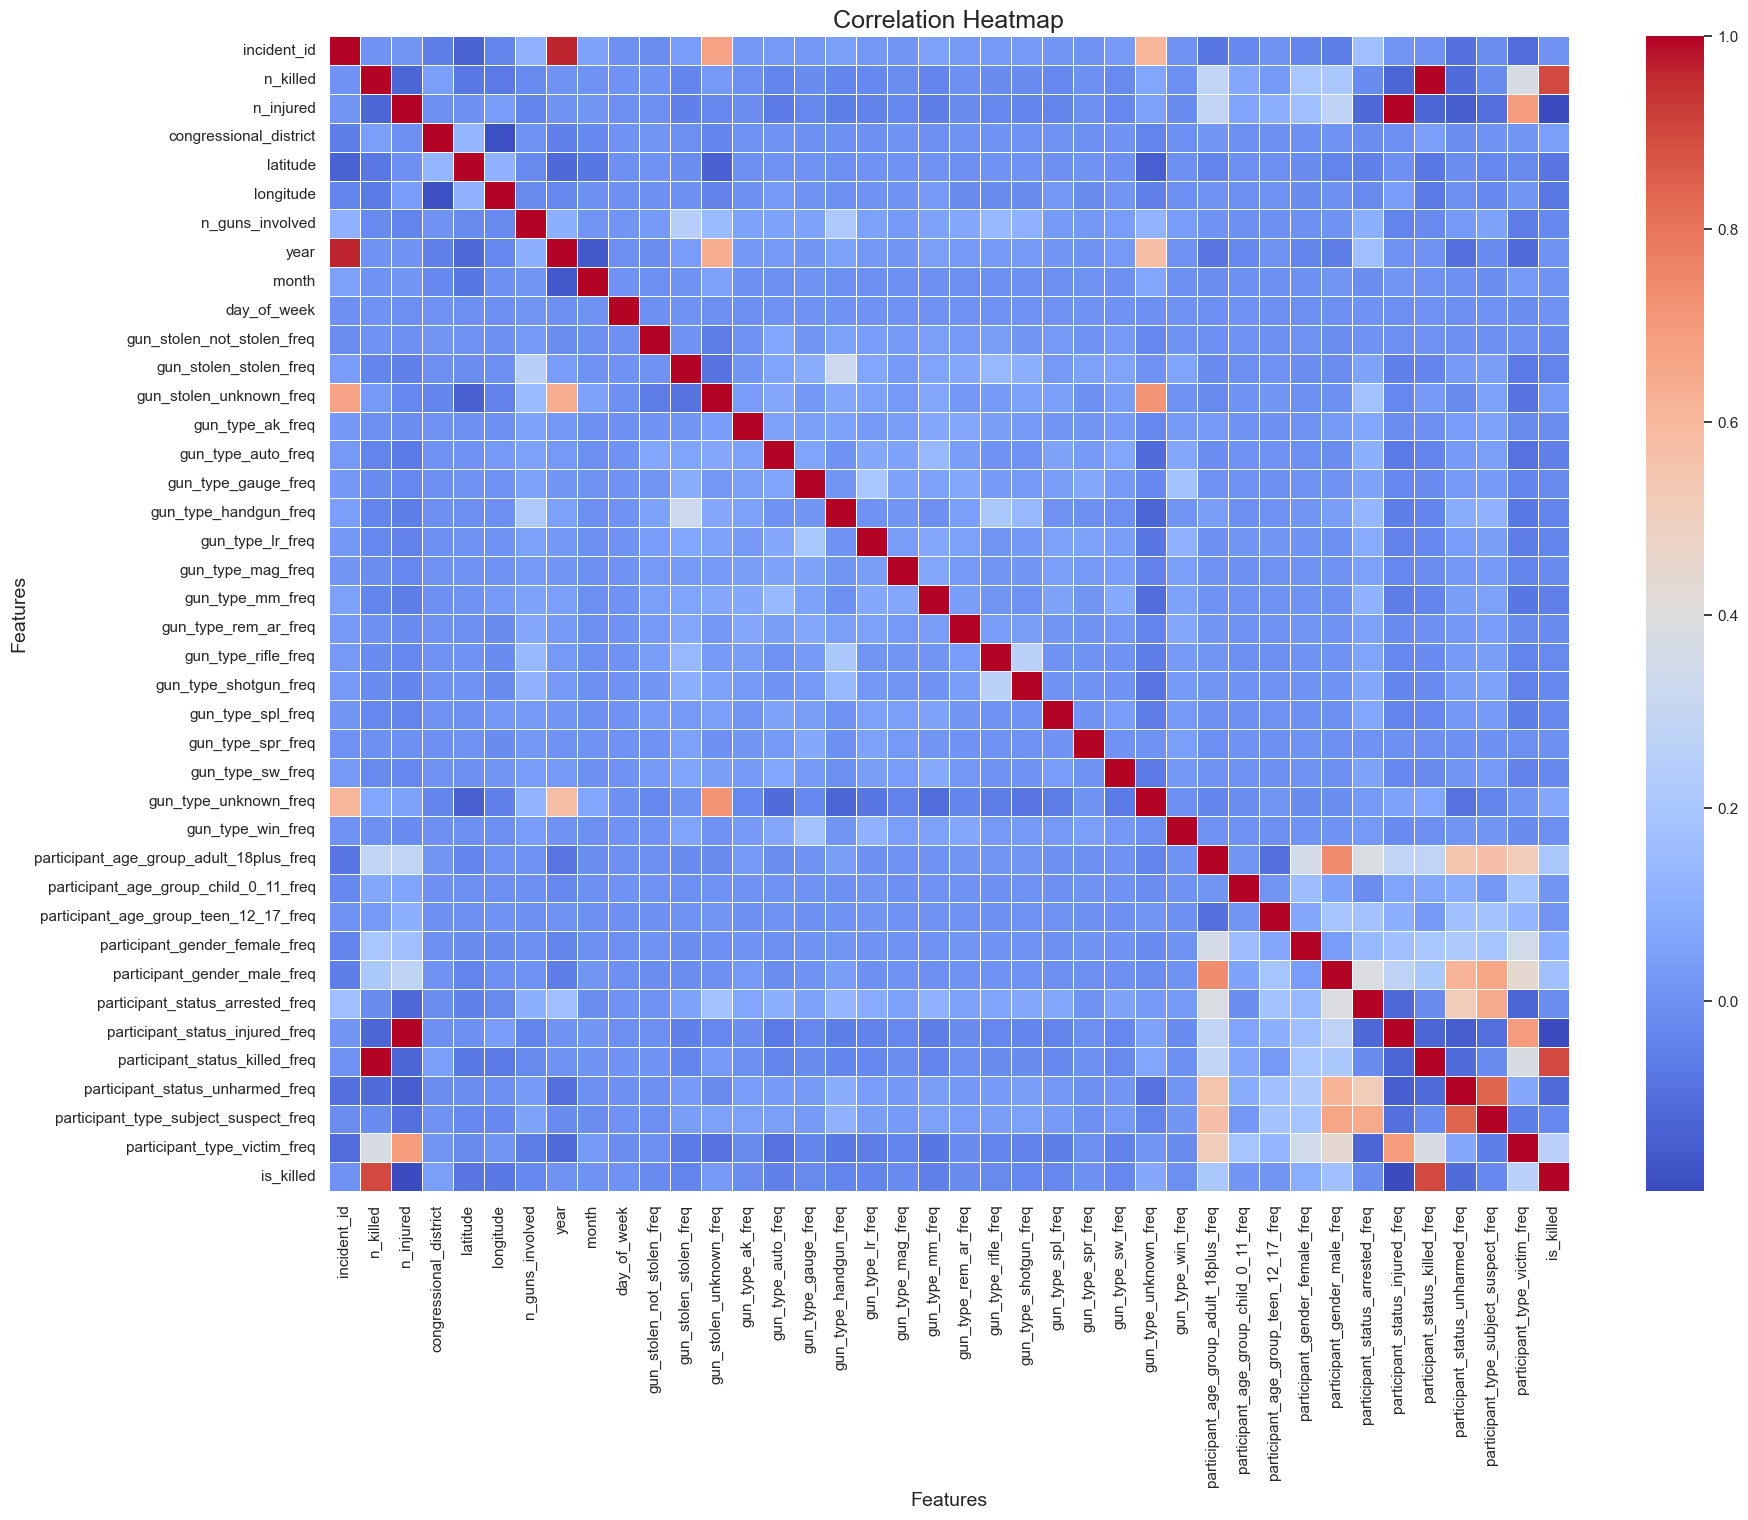

In [70]:
correlation_matrix = df_corr.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, linewidths=0.5)

plt.title("Correlation Heatmap", fontsize=18)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Features", fontsize=14)

plt.show()

Dropping columns which we won't be using.

In [72]:
cols_to_drop = ["n_killed", "incident_id", "date", "address", "congressional_district", 
                "incident_characteristics", "latitude", "longitude", "notes", "city_or_county",
                "participant_status_injured_freq", "participant_status_killed_freq", "participant_status_arrested_freq",
                "participant_status_unharmed_freq", "participant_type_subject_suspect_freq", "participant_type_victim_freq"]

class_ip_data = class_ip_data.drop(*cols_to_drop)

In [73]:
non_numeric_columns = [field.name for field in class_ip_data.schema.fields if not isinstance(field.dataType, (IntegerType, FloatType, DoubleType))]

print("Non-integer and non-float columns:", non_numeric_columns)

Non-integer and non-float columns: ['state']


In [74]:
def encode_multiple_columns_with_string_indexer(df, columns):
    """
    Function to encode multiple columns using StringIndexer.
    
    Parameters:
    df (DataFrame): The input DataFrame.
    columns (list): List of column names to be indexed.
    
    Returns:
    DataFrame: DataFrame with the new indexed columns.
    """
    indexers = [StringIndexer(inputCol=cols, outputCol=cols + "_indexed") for cols in columns]
    
    pipeline = Pipeline(stages=indexers)
    indexed_df = pipeline.fit(df).transform(df)
    
    return indexed_df

In [75]:
train_data, temp_data = class_ip_data.randomSplit([0.6, 0.4], seed=42)
validation_data, test_data = temp_data.randomSplit([0.5, 0.5], seed=42)

In [76]:
train_data = encode_multiple_columns_with_string_indexer(train_data, non_numeric_columns)
validation_data = encode_multiple_columns_with_string_indexer(validation_data, non_numeric_columns)
test_data = encode_multiple_columns_with_string_indexer(test_data, non_numeric_columns)

In [77]:
train_data = train_data.drop(*non_numeric_columns)
validation_data = validation_data.drop(*non_numeric_columns)
test_data = test_data.drop(*non_numeric_columns)

In [78]:
for cols in non_numeric_columns:
    train_data = train_data.withColumnRenamed(cols + "_indexed", cols)
    validation_data = validation_data.withColumnRenamed(cols + "_indexed", cols)
    test_data = test_data.withColumnRenamed(cols + "_indexed", cols)

#### Feature Vectorization

In [80]:
feature_columns = [cols for cols in train_data.columns if cols not in ['is_killed']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [81]:
train_data = assembler.transform(train_data).select("features", "is_killed")
validation_data = assembler.transform(validation_data).select("features", "is_killed")
test_data = assembler.transform(test_data).select("features", "is_killed")

### Training with Class Weights to handle Class Imbalance

In [83]:
class_counts = train_data.groupBy("is_killed").count().collect()
total_count = train_data.count()
weights = {row['is_killed']: total_count / row['count'] for row in class_counts}

In [84]:
train_data_cl_wghts = train_data.select("*")

In [85]:
train_data_cl_wghts = train_data_cl_wghts.withColumn("weight", when(col("is_killed") == 1, weights[1]).otherwise(weights[0]))

#### Model Training and Evaluation

In [87]:
log_reg = LogisticRegression(featuresCol='features', labelCol='is_killed', weightCol='weight')
rf = RandomForestClassifier(featuresCol='features', labelCol='is_killed', weightCol='weight', maxBins=64, seed=42)
dt = DecisionTreeClassifier(featuresCol='features', labelCol='is_killed', weightCol='weight', maxBins=64, seed=42)
gbt = GBTClassifier(featuresCol='features', labelCol='is_killed', weightCol='weight', maxBins=64, seed=42)
svm = LinearSVC(featuresCol='features', labelCol='is_killed', weightCol='weight')

In [88]:
models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf,
    'Decision Tree': dt,
    'GBT': gbt,
    'SVM': svm
}

evaluator = BinaryClassificationEvaluator(labelCol='is_killed')

In [89]:
%%time
model_performance = {}
best_model = None
best_auc = 0.0

evaluator = BinaryClassificationEvaluator(labelCol="is_killed", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

for model_name, model in models.items():
    trained_model = model.fit(train_data_cl_wghts)
    train_predictions = trained_model.transform(train_data_cl_wghts)
    validation_predictions = trained_model.transform(validation_data)
    
    train_auc = evaluator.evaluate(train_predictions)
    val_auc = evaluator.evaluate(validation_predictions)
    
    print(f"{model_name} - AUC on Validation Data: Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")
    model_performance[model_name] = {'Train AUC': train_auc, 'Validation AUC': val_auc}
    
    if val_auc > best_auc:
        best_auc = val_auc
        best_model = trained_model

Logistic Regression - AUC on Validation Data: Train AUC: 0.8218, Validation AUC: 0.8224


Random Forest - AUC on Validation Data: Train AUC: 0.8414, Validation AUC: 0.8346


Decision Tree - AUC on Validation Data: Train AUC: 0.8227, Validation AUC: 0.8241


GBT - AUC on Validation Data: Train AUC: 0.8798, Validation AUC: 0.8661


SVM - AUC on Validation Data: Train AUC: 0.8211, Validation AUC: 0.8219
CPU times: user 62.3 ms, sys: 35.2 ms, total: 97.5 ms
Wall time: 60 s


In [90]:
model_names = list(model_performance.keys())
train_aucs = [model_performance[model]['Train AUC'] for model in model_names]
val_aucs = [model_performance[model]['Validation AUC'] for model in model_names]

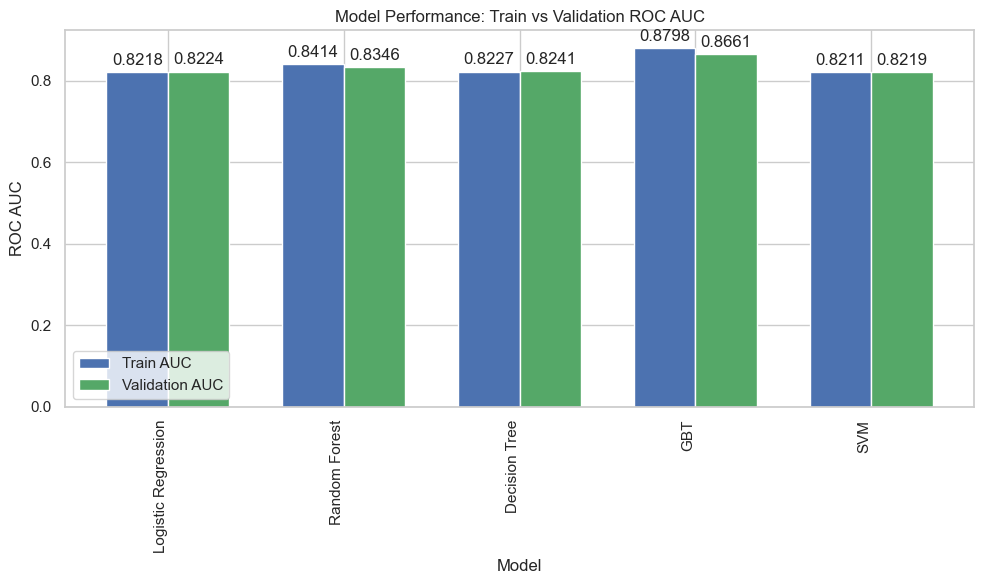

In [91]:
x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_aucs, width, label='Train AUC', color='b')
rects2 = ax.bar(x + width/2, val_aucs, width, label='Validation AUC', color='g')

ax.set_xlabel('Model')
ax.set_ylabel('ROC AUC')
ax.set_title('Model Performance: Train vs Validation ROC AUC')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=90, ha="right")
ax.legend()

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
plt.tight_layout()
plt.show()

In [92]:
test_predictions = best_model.transform(test_data)
final_auc = evaluator.evaluate(test_predictions)

print(f"\nBest Model: {best_model.__class__.__name__} with Validation AUC: {best_auc:.4f}")
print(f"Final AUC on Test Data: {final_auc:.4f}")


Best Model: GBTClassificationModel with Validation AUC: 0.8661
Final AUC on Test Data: 0.8679


In [93]:
test_predictions_df = test_predictions.select('is_killed', 'probability').toPandas()

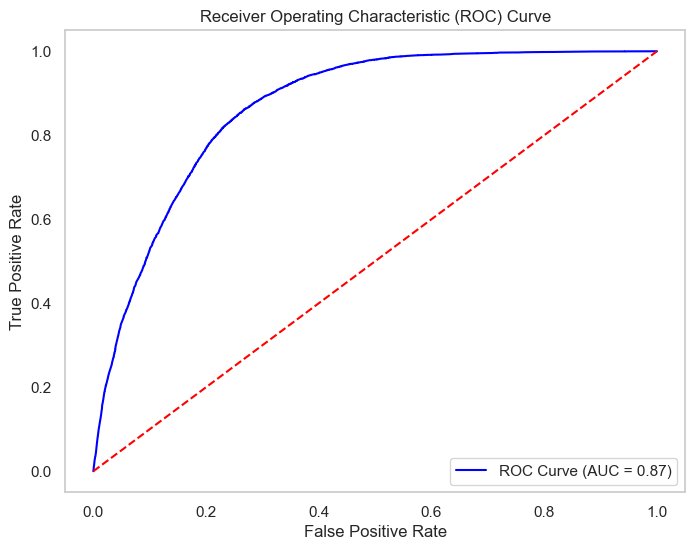

In [94]:
y_true = test_predictions_df['is_killed']
y_scores = test_predictions_df['probability'].apply(lambda x: float(x[1]))  # Probability of class 1

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [95]:
y_pred = test_predictions_df['probability'].apply(lambda x: 1 if x[1] >= 0.5 else 0)
conf_matrix = confusion_matrix(y_true, y_pred)

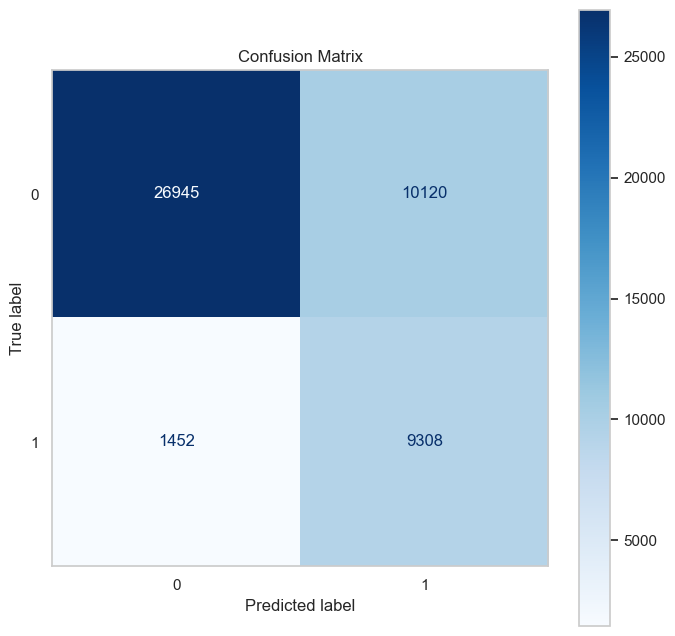

In [96]:
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d', ax=ax)
ax.grid(False)
plt.title("Confusion Matrix")
plt.show()

In [97]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
accuracy = accuracy_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.4791
Recall: 0.8651
F1 Score: 0.6167
Accuracy: 0.7580


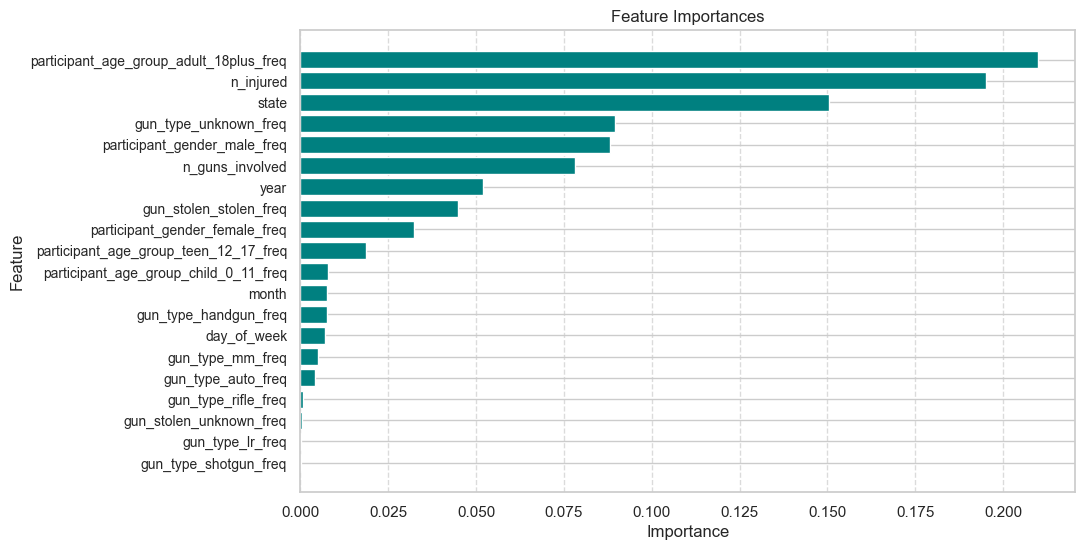

In [98]:
if hasattr(best_model, "featureImportances"):
    feature_importances = best_model.featureImportances.toArray()

    non_zero_features = [(feature, importance) for feature, importance in zip(feature_columns, feature_importances) if importance > 0]
    feature_importances_df = pd.DataFrame(non_zero_features, columns=['feature', 'importance'])
    
    feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances_df['feature'], feature_importances_df['importance'], color='teal')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.yticks(fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.gca().invert_yaxis()

    plt.show()
else:
    print("Feature importance is not available for this model.")

### Hyperparameter Tuning - on the best model

We have gotten the Gradient Boosting the best model, so we will be performing hyper parameter tuning.

In [100]:
gbt = GBTClassifier(featuresCol='features', labelCol='is_killed', weightCol='weight', seed=42)

In [102]:
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 7]) \
    .addGrid(gbt.maxBins, [64, 96, 128]) \
    .addGrid(gbt.maxIter, [20, 30, 40]) \
    .build()

In [104]:
cv = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    seed=42
)

In [106]:
def calculate_learning_curves(model, train_data, validation_data, steps=10):
    train_sizes = np.linspace(0.1, 1.0, steps)
    train_scores = []
    val_scores = []
    
    for size in train_sizes:
        train_subset = train_data.sample(False, size, seed=42)
        
        model_fitted = model.fit(train_subset)
        train_pred = model_fitted.transform(train_subset)
        val_pred = model_fitted.transform(validation_data)

        train_score = evaluator.evaluate(train_pred)
        val_score = evaluator.evaluate(val_pred)
        
        train_scores.append(train_score)
        val_scores.append(val_score)
    
    return train_sizes, train_scores, val_scores

In [108]:
%%time
cv_model = cv.fit(train_data_cl_wghts)

best_model = cv_model.bestModel

print("Best Model Parameters:")
print(f"maxDepth: {best_model.getMaxDepth()}")
print(f"maxBins: {best_model.getMaxBins()}")
print(f"maxIter: {best_model.getMaxIter()}")
print(f"stepSize: {best_model.getStepSize()}")

24/11/16 13:53:47 WARN DAGScheduler: Broadcasting large task binary with size 1001.4 KiB
24/11/16 13:53:47 WARN DAGScheduler: Broadcasting large task binary with size 1010.3 KiB
24/11/16 13:53:48 WARN DAGScheduler: Broadcasting large task binary with size 1010.8 KiB
24/11/16 13:53:48 WARN DAGScheduler: Broadcasting large task binary with size 1011.3 KiB
24/11/16 13:53:48 WARN DAGScheduler: Broadcasting large task binary with size 1013.0 KiB
24/11/16 13:53:48 WARN DAGScheduler: Broadcasting large task binary with size 1017.4 KiB
24/11/16 13:53:48 WARN DAGScheduler: Broadcasting large task binary with size 1023.2 KiB
24/11/16 13:53:48 WARN DAGScheduler: Broadcasting large task binary with size 1035.0 KiB
24/11/16 13:53:48 WARN DAGScheduler: Broadcasting large task binary with size 1044.7 KiB
24/11/16 13:53:48 WARN DAGScheduler: Broadcasting large task binary with size 1045.1 KiB
24/11/16 13:53:48 WARN DAGScheduler: Broadcasting large task binary with size 1045.7 KiB
24/11/16 13:53:48 WAR

Best Model Parameters:
maxDepth: 7
maxBins: 128
maxIter: 40
stepSize: 0.1
CPU times: user 805 ms, sys: 544 ms, total: 1.35 s
Wall time: 13min 43s


In [120]:
# metrics = cv_model.avgMetrics

# param_combinations = [
#     f"maxDepth={p['maxDepth']}\nmaxBins={p['maxBins']}\nmaxIter={p['maxIter']}\nstepSize={p['stepSize']}"
#     for p in paramGrid
# ]

# plt.figure(figsize=(15, 6))
# plt.bar(range(len(metrics)), metrics)
# plt.xticks(range(len(metrics)), param_combinations, rotation=90)
# plt.xlabel('Parameter Combinations')
# plt.ylabel('Average AUC-ROC')
# plt.title('Hyperparameter Tuning Results')
# plt.tight_layout()
# plt.show()

In [114]:
paramGrid

[{Param(parent='GBTClassifier_15807fa97756', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5,
  Param(parent='GBTClassifier_15807fa97756', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 64,
  Param(parent='GBTClassifier_15807fa97756', name='maxIter', doc='max number of iterations (>= 0).'): 20},
 {Param(parent='GBTClassifier_15807fa97756', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5,
  Param(parent='GBTClassifier_15807fa97756', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 64,
  Param(parent='GBTClassifier_15807fa97756', name='maxIter', doc='max

In [122]:
# train_sizes, train_scores, val_scores = calculate_learning_curves(
#     best_model, train_data_cl_wghts, validation_data
# )

# plt.figure(figsize=(10, 6))
# plt.plot(train_sizes, train_scores, label='Training Score', marker='o')
# plt.plot(train_sizes, val_scores, label='Validation Score', marker='o')
# plt.xlabel('Training Set Size (%)')
# plt.ylabel('AUC-ROC Score')
# plt.title('Learning Curves - Bias-Variance Trade-off Analysis')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [118]:
test_predictions = best_model.transform(test_data)
final_auc = evaluator.evaluate(test_predictions)
print(f"\nFinal Test Set AUC: {final_auc:.4f}")

24/11/16 14:11:27 WARN DAGScheduler: Broadcasting large task binary with size 1515.9 KiB



Final Test Set AUC: 0.8726
